In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

print("Library Versions:")
print('numpy:',np.__version__)
print('pandas:',pd.__version__)
print('tensorflow:',tf.__version__)
print('tensorflow probability:', tfp.__version__)

2023-10-21 04:44:08.588191: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-21 04:44:08.652692: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-21 04:44:09.600019: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Library Versions:
numpy: 1.26.0
pandas: 2.1.1
tensorflow: 2.13.1
tensorflow probability: 0.21.0


In [2]:
from art.attacks.evasion import ProjectedGradientDescent
from art.estimators.classification import TensorFlowV2Classifier
from art.data_generators import KerasDataGenerator
from art.defences.trainer import AdversarialTrainer

In [3]:
n_epochs = 200
verbose_option = True

# Classification for Ship Detection


Load Ship Detection Dataset

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

ROOT_PATH = "shipsnet"
BATCH_SIZE=1000
def normalize_img(image, label):
    return (tf.cast(image, tf.float32) / 255.0, label)

# https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
train_dataset, test_dataset = tf.keras.utils.image_dataset_from_directory(ROOT_PATH,
                            labels = 'inferred',
                            label_mode = 'categorical',
                            class_names = None,
                            color_mode = "rgb",
                            batch_size = BATCH_SIZE,
                            image_size = (80, 80),
                            shuffle = True,
                            seed = 42,
                            subset="both",
                            validation_split = 0.2,
)

train_dataset = train_dataset.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.cache()
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

test_dataset = test_dataset.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache()
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

Found 4000 files belonging to 2 classes.
Using 3200 files for training.
Using 800 files for validation.


2023-10-21 04:44:22.597512: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46497 MB memory:  -> device: 0, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:1c:00.0, compute capability: 8.9


In [5]:
x_train, y_train = list(train_dataset.as_numpy_iterator())[0]
x_test, y_test = list(test_dataset.as_numpy_iterator())[0]

Using Tensoflow, perform  non-linear binary classification model for the classification dataset.

In [6]:
def build_model():
    inputs = layers.Input(shape=(80,80,3))
    flat = layers.Flatten()(inputs)
    h1 = layers.Dense(50, activation="relu")(flat) #TODO: Call a Keras Tensorflow Dense layer constructor for 50 ReLU neurons and call it on the flattened input
    h2 = layers.Dense(50, activation="relu")(h1) #TODO: Call a Keras Tensorflow Dense layer constructor for 50 ReLU neurons and call it on h1
    h3 = layers.Dense(50, activation="relu")(h2) #TODO: Call a Keras Tensorflow Dense layer constructor for 50 ReLU neurons and call it on h2
    p = layers.Dense(2,activation=tf.keras.activations.softmax)(h3) #TODO: Call the Dense layer constructor to compute the prediction for p(y=1|x,theta)

    model = keras.Model(inputs=inputs, outputs=p)

    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
        optimizer=tf.keras.optimizers.Adam(1e-3),
        metrics=[tf.keras.metrics.CategoricalAccuracy(),
        tf.keras.metrics.CategoricalCrossentropy(from_logits=False)]
    )
    return model

In [7]:
model = build_model()

In [8]:
model.fit(train_dataset, epochs=n_epochs, verbose=True)#verbose_option)

Epoch 1/200


2023-10-21 04:44:32.781615: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-21 04:44:32.792384: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f0938031d10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-21 04:44:32.792414: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
2023-10-21 04:44:32.799692: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-21 04:44:33.025911: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-21 04:44:33.382127: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime o

4/4 [==============================] - 4s 18ms/step - loss: 1.3506 - categorical_accuracy: 0.6137 - categorical_crossentropy: 1.3506
Epoch 2/200
4/4 [==============================] - 0s 16ms/step - loss: 0.9544 - categorical_accuracy: 0.7572 - categorical_crossentropy: 0.9544
Epoch 3/200
4/4 [==============================] - 0s 16ms/step - loss: 0.7214 - categorical_accuracy: 0.7588 - categorical_crossentropy: 0.7214
Epoch 4/200
4/4 [==============================] - 0s 16ms/step - loss: 0.5734 - categorical_accuracy: 0.7647 - categorical_crossentropy: 0.5734
Epoch 5/200
4/4 [==============================] - 0s 16ms/step - loss: 0.4717 - categorical_accuracy: 0.7853 - categorical_crossentropy: 0.4717
Epoch 6/200
4/4 [==============================] - 0s 16ms/step - loss: 0.4549 - categorical_accuracy: 0.8141 - categorical_crossentropy: 0.4549
Epoch 7/200
4/4 [==============================] - 0s 16ms/step - loss: 0.4298 - categorical_accuracy: 0.8244 - categorical_crossentropy: 0.42

4/4 [==============================] - 0s 16ms/step - loss: 0.1626 - categorical_accuracy: 0.9381 - categorical_crossentropy: 0.1626
Epoch 114/200
4/4 [==============================] - 0s 16ms/step - loss: 0.1648 - categorical_accuracy: 0.9381 - categorical_crossentropy: 0.1648
Epoch 115/200
4/4 [==============================] - 0s 16ms/step - loss: 0.1735 - categorical_accuracy: 0.9331 - categorical_crossentropy: 0.1735
Epoch 116/200
4/4 [==============================] - 0s 16ms/step - loss: 0.1598 - categorical_accuracy: 0.9369 - categorical_crossentropy: 0.1598
Epoch 117/200
4/4 [==============================] - 0s 16ms/step - loss: 0.1466 - categorical_accuracy: 0.9438 - categorical_crossentropy: 0.1466
Epoch 118/200
4/4 [==============================] - 0s 16ms/step - loss: 0.1475 - categorical_accuracy: 0.9481 - categorical_crossentropy: 0.1475
Epoch 119/200
4/4 [==============================] - 0s 16ms/step - loss: 0.1397 - categorical_accuracy: 0.9481 - categorical_crosse

Evaluate the classification model on the test data

In [9]:
model.evaluate(test_dataset.take(-1))

1/1 [==============================] - 0s 208ms/step - loss: 0.1661 - categorical_accuracy: 0.9425 - categorical_crossentropy: 0.1661


[0.16611264646053314, 0.9424999952316284, 0.16611264646053314]

1. Train a classifier using PGD-based adversarial training

In [10]:
classifier = TensorFlowV2Classifier(build_model(), nb_classes=2, input_shape=[80,80,3],loss_object=tf.keras.losses.CategoricalCrossentropy(from_logits=False),optimizer=tf.keras.optimizers.Adam(1e-3), clip_values=(0, 1))

In [11]:
pgd = ProjectedGradientDescent(classifier,eps=0.02,eps_step = 0.01,batch_size=x_train.shape[0])

In [12]:
adv_trainer = AdversarialTrainer(classifier, attacks=pgd, ratio=0.5)

In [13]:
adv_trainer.fit(x=x_train,y=y_train, batch_size=x_train.shape[0], nb_epochs=n_epochs)

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/200 [00:00<?, ?it/s]

In [78]:
examples, labels = list(test_dataset.as_numpy_iterator())[0]

In [79]:
(np.argmax(classifier.predict(examples),axis=1)==np.argmax(labels,axis=1)).mean()

0.86125

Evaluate the standard classification model on a test example and 0-targeted PGD examples using epislons of 0.01, 0.03, and 0.1

In [80]:
model(np.reshape(examples[0],[1,80,80,3])).numpy()[0]

array([0.02373479, 0.97626525], dtype=float32)

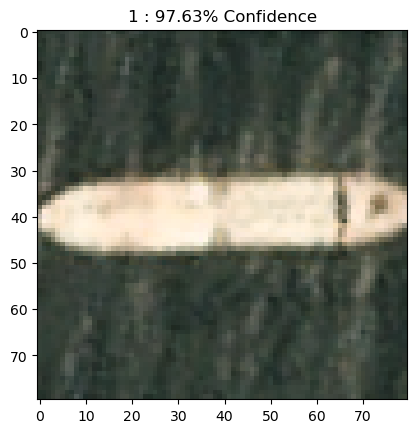

In [81]:
plt.figure()
plt.imshow(examples[5])
confidence = model(np.reshape(examples[0],[1,80,80,3])).numpy()[0,1]
if confidence < 0.5:
    pred = 0
    confidence = 1. - confidence
else:
    pred = 1
plt.title('{} : {:.2f}% Confidence'.format(str(pred), confidence*100))
plt.show()

In [82]:
def create_adversarial_pattern(model,input_example, target,loss_object,steps=5):
    input_example = tf.convert_to_tensor(input_example)
    noise = tf.zeros_like(input_example)
    for i in range(steps):
        with tf.GradientTape() as tape:
            tape.watch(noise)
            prediction = model(input_example+noise)
            loss = loss_object(target, prediction)
    
            # Get the gradients of the loss w.r.t to the input example.
        gradient = tape.gradient(loss, noise)
            # Get the sign of the gradients to create the perturbation
        noise += tf.sign(gradient)*0.01
        noise = tf.clip_by_value(noise, -0.03, 0.03) 
    return noise

In [83]:
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
noise_np = create_adversarial_pattern(model,np.reshape(examples[5],[1,80,80,3]), np.array([[1,0]]),loss_object)

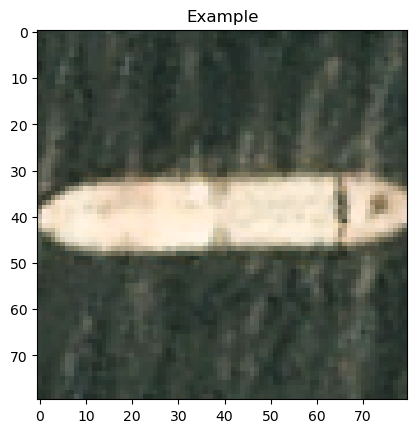

In [84]:
plt.figure()
plt.imshow(examples[5])
plt.title('Example')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


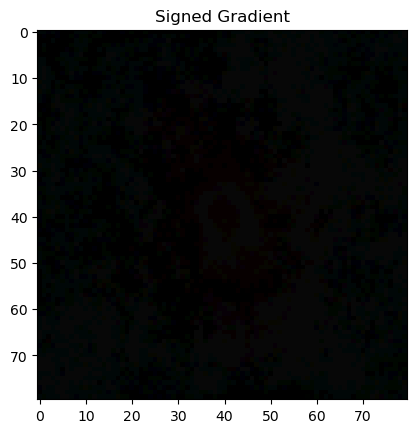

In [85]:
plt.figure()
plt.imshow(noise_np[0])
plt.title('Signed Gradient')
plt.show()

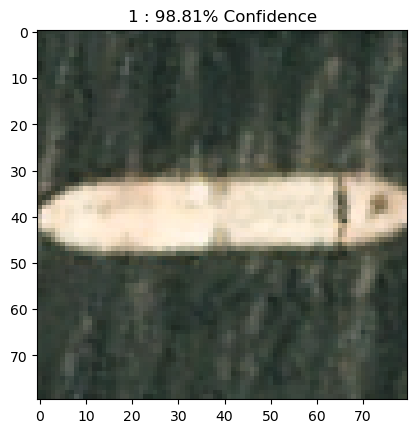

In [86]:
plt.figure()
adv_example = examples[5]-noise_np[0]*0.01
plt.imshow(np.clip(adv_example,0,1))
confidence = model(np.reshape(adv_example,[1,80,80,3])).numpy()[0,1]
if confidence < 0.5:
    pred = 0
    confidence = 1. - confidence
else:
    pred = 1
plt.title('{} : {:.2f}% Confidence'.format(str(pred), confidence*100))
plt.show()

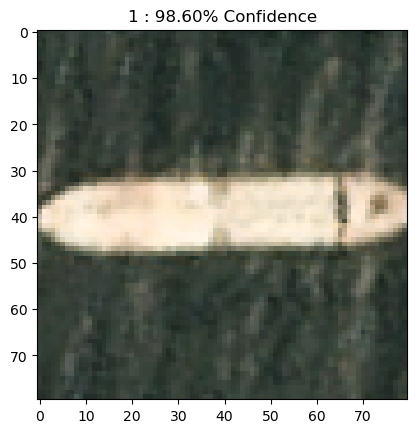

In [87]:
plt.figure()
adv_example = examples[5]-noise_np[0]*0.03
plt.imshow(np.clip(adv_example,0,1))
confidence = model(np.reshape(adv_example,[1,80,80,3])).numpy()[0,1]
if confidence < 0.5:
    pred = 0
    confidence = 1. - confidence
else:
    pred = 1
plt.title('{} : {:.2f}% Confidence'.format(str(pred), confidence*100))
plt.show()

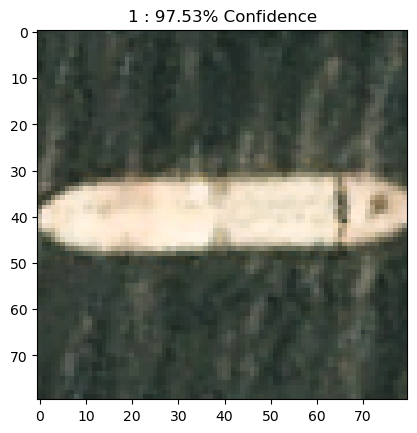

In [88]:
plt.figure()
adv_example = examples[5]-noise_np[0]*0.1
plt.imshow(np.clip(adv_example,0,1))
confidence = model(np.reshape(adv_example,[1,80,80,3])).numpy()[0,1]
if confidence < 0.5:
    pred = 0
    confidence = 1. - confidence
else:
    pred = 1
plt.title('{} : {:.2f}% Confidence'.format(str(pred), confidence*100))
plt.show()

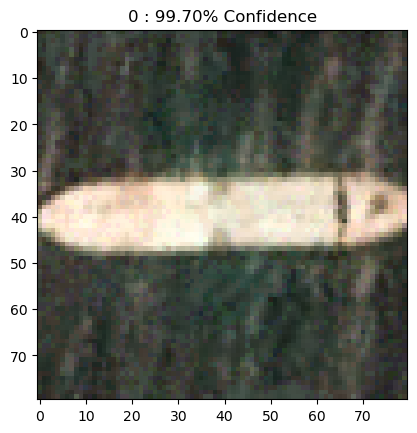

In [90]:
plt.figure()
adv_example = examples[5]-noise_np[0]
plt.imshow(np.clip(adv_example,0,1))
confidence = model(np.reshape(adv_example,[1,80,80,3])).numpy()[0,1]
if confidence < 0.5:
    pred = 0
    confidence = 1. - confidence
else:
    pred = 1
plt.title('{} : {:.2f}% Confidence'.format(str(pred), confidence*100))
plt.show()

2. Evaluate the classification model with adversarial training on a test example and 0-targeted PGD examples using epislons of 0.01, 0.03, and 0.1

In [91]:
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
noise_np = create_adversarial_pattern(classifier.model,np.reshape(examples[5],[1,80,80,3]), np.array([[1,0]]),loss_object)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


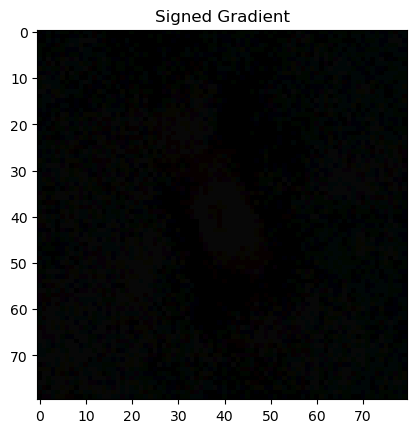

In [92]:
plt.figure()
plt.imshow(noise_np[0])
plt.title('Signed Gradient')
plt.show()

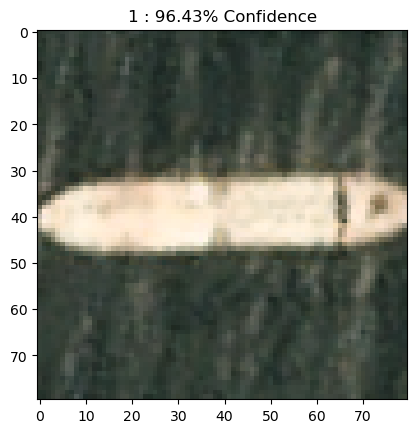

In [93]:
plt.figure()
plt.imshow(examples[5])
confidence = classifier.predict(np.reshape(examples[5],[1,80,80,3]))[0,1]
if confidence < 0.5:
    pred = 0
    confidence = 1. - confidence
else:
    pred = 1
plt.title('{} : {:.2f}% Confidence'.format(str(pred), confidence*100))
plt.show()

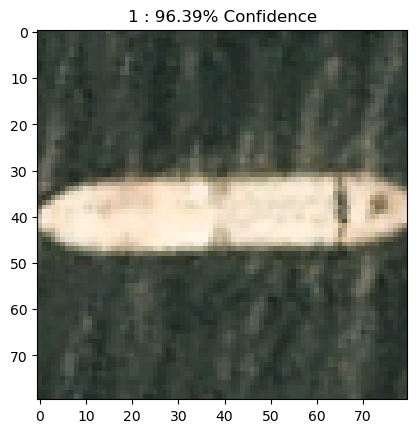

In [94]:
plt.figure()
adv_example = examples[5]-noise_np[0]*0.01
plt.imshow(np.clip(adv_example,0,1))
confidence = classifier.predict(np.reshape(adv_example,[1,80,80,3]))[0,1]
if confidence < 0.5:
    pred = 0
    confidence = 1. - confidence
else:
    pred = 1
plt.title('{} : {:.2f}% Confidence'.format(str(pred), confidence*100))
plt.show()

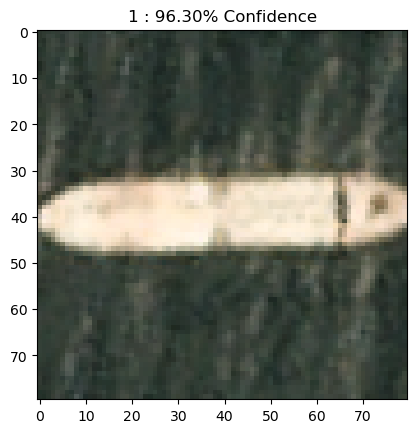

In [95]:
plt.figure()
adv_example = examples[5]-noise_np[0]*0.03
plt.imshow(np.clip(adv_example,0,1))
confidence = classifier.predict(np.reshape(adv_example,[1,80,80,3]))[0,1]
if confidence < 0.5:
    pred = 0
    confidence = 1. - confidence
else:
    pred = 1
plt.title('{} : {:.2f}% Confidence'.format(str(pred), confidence*100))
plt.show()

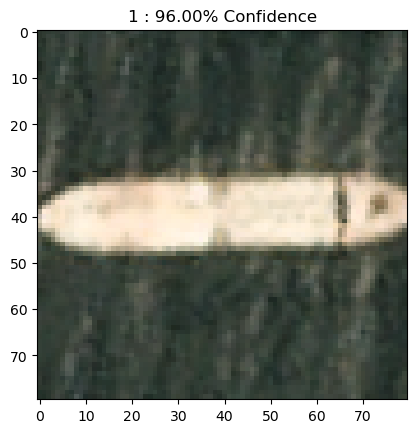

In [96]:
plt.figure()
adv_example = examples[5]-noise_np[0]*0.1
plt.imshow(np.clip(adv_example,0,1))
confidence = classifier.predict(np.reshape(adv_example,[1,80,80,3]))[0,1]
if confidence < 0.5:
    pred = 0
    confidence = 1. - confidence
else:
    pred = 1
plt.title('{} : {:.2f}% Confidence'.format(str(pred), confidence*100))
plt.show()

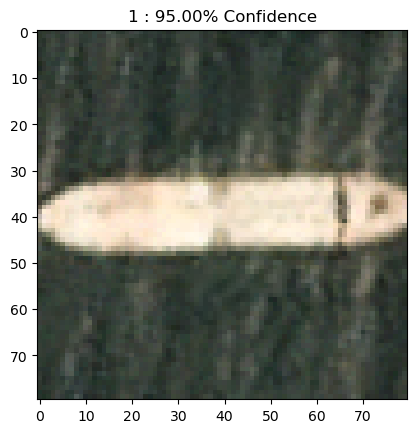

In [97]:
plt.figure()
adv_example = examples[5]-noise_np[0]*0.3
plt.imshow(np.clip(adv_example,0,1))
confidence = classifier.predict(np.reshape(adv_example,[1,80,80,3]))[0,1]
if confidence < 0.5:
    pred = 0
    confidence = 1. - confidence
else:
    pred = 1
plt.title('{} : {:.2f}% Confidence'.format(str(pred), confidence*100))
plt.show()

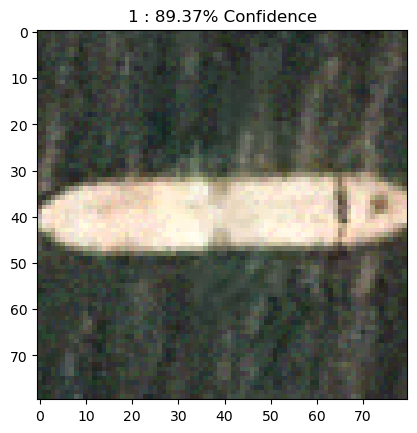

In [98]:
plt.figure()
adv_example = examples[5]-noise_np[0]
plt.imshow(np.clip(adv_example,0,1))
confidence = classifier.predict(np.reshape(adv_example,[1,80,80,3]))[0,1]
if confidence < 0.5:
    pred = 0
    confidence = 1. - confidence
else:
    pred = 1
plt.title('{} : {:.2f}% Confidence'.format(str(pred), confidence*100))
plt.show()